In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
!pip install seaborn

# **Exploratory Data Analysis**

In [3]:
# Load in df
df = pd.read_csv('stats.csv')
df.head()

,"last_name, first_name",player_id,year,ab,pa,home_run,strikeout,walk,k_percent,bb_percent,...,b_swinging_strike,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,"Beltré, Adrian",134181,2017,340,389,17,52,39,13.4,10.0,...,122,0.384,0.358,36.1,5.8,32.5,97.066970,92.551073,18.7,46.8
1,"Beltrán, Carlos",136860,2017,467,509,14,102,33,20.0,6.5,...,146,0.283,0.284,29.4,4.6,31.0,97.251447,92.653848,19.8,47.9
2,"Werth, Jayson",150029,2017,252,289,10,69,35,23.9,12.1,...,92,0.311,0.329,33.2,8.2,40.7,99.992580,94.104058,21.9,38.6
3,"Arroyo, Bronson",276520,2017,26,29,0,10,0,34.5,0.0,...,10,0.135,0.210,36.8,0.0,0.0,89.654834,89.315833,26.2,50.0
4,"Dickey, R.A.",285079,2017,61,68,0,12,0,17.6,0.0,...,17,0.129,0.139,19.6,0.0,0.0,83.338039,88.117691,14.8,74.3


In [4]:
# Shape of dataset
rows, cols = df.shape[0], df.shape[0]

print(f'Number of Rows: {rows}')
print(f'Number of Columns: {cols}')

Number of Rows: 5419
Number of Columns: 5419


In [5]:
# All columns
print(df.columns)

Index(['last_name, first_name', 'player_id', 'year', 'ab', 'pa', 'home_run',
       'strikeout', 'walk', 'k_percent', 'bb_percent', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'b_rbi',
       'b_swinging_strike', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent'],
      dtype='object')


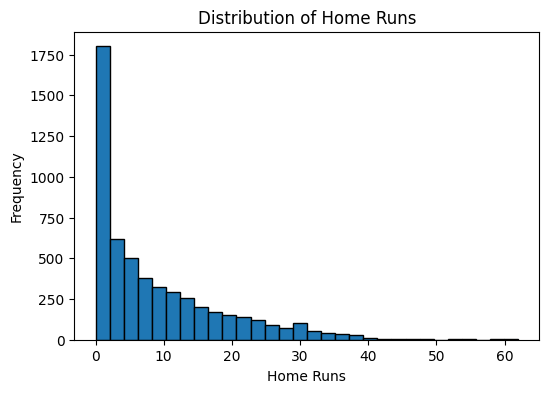

In [6]:
# distribution of target variable
plt.figure(figsize=(6,4))
plt.hist(df["home_run"], bins=30, edgecolor="black")
plt.xlabel("Home Runs")
plt.ylabel("Frequency")
plt.title("Distribution of Home Runs")
plt.show()

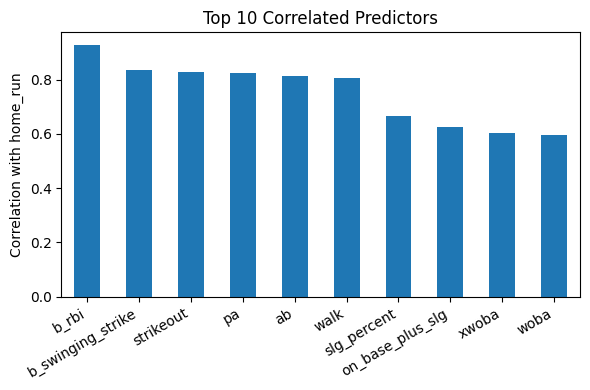

In [7]:
# top 10 correlations with home_run
corrs = df.corr(numeric_only=True)["home_run"].drop("home_run").sort_values(key=abs, ascending=False)
top10 = corrs.head(10)

plt.figure(figsize=(6,4))
top10.plot(kind="bar")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Correlation with home_run")
plt.title("Top 10 Correlated Predictors")
plt.tight_layout()
plt.show()


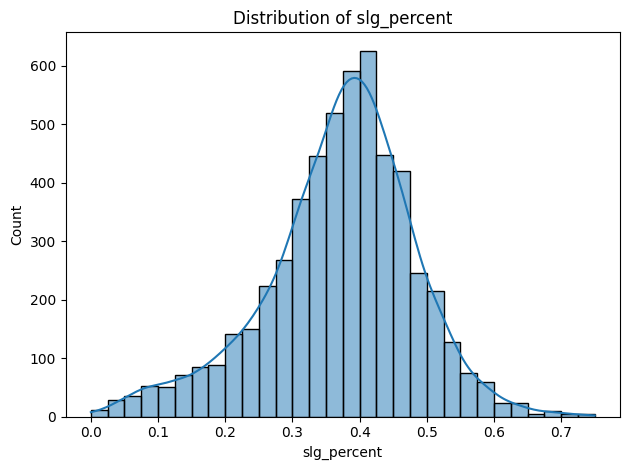

In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['slg_percent'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'slg_percent'}")
plt.xlabel('slg_percent')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

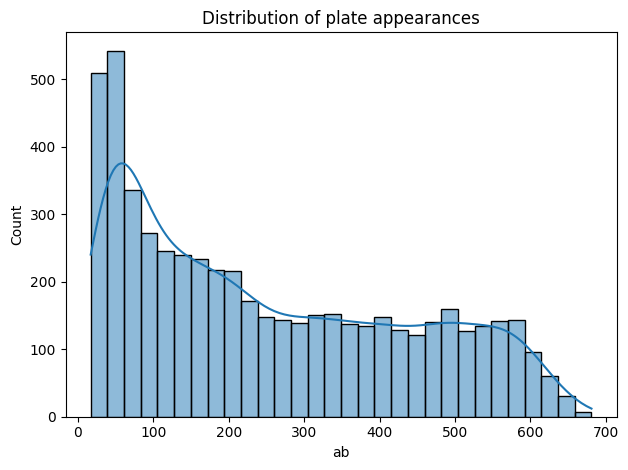

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['ab'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'plate appearances'}")
plt.xlabel('ab')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [10]:
# Filtering out rows where 'ab' (plate appearances) is less than or equal to 100
df = df[df['ab'] > 100]

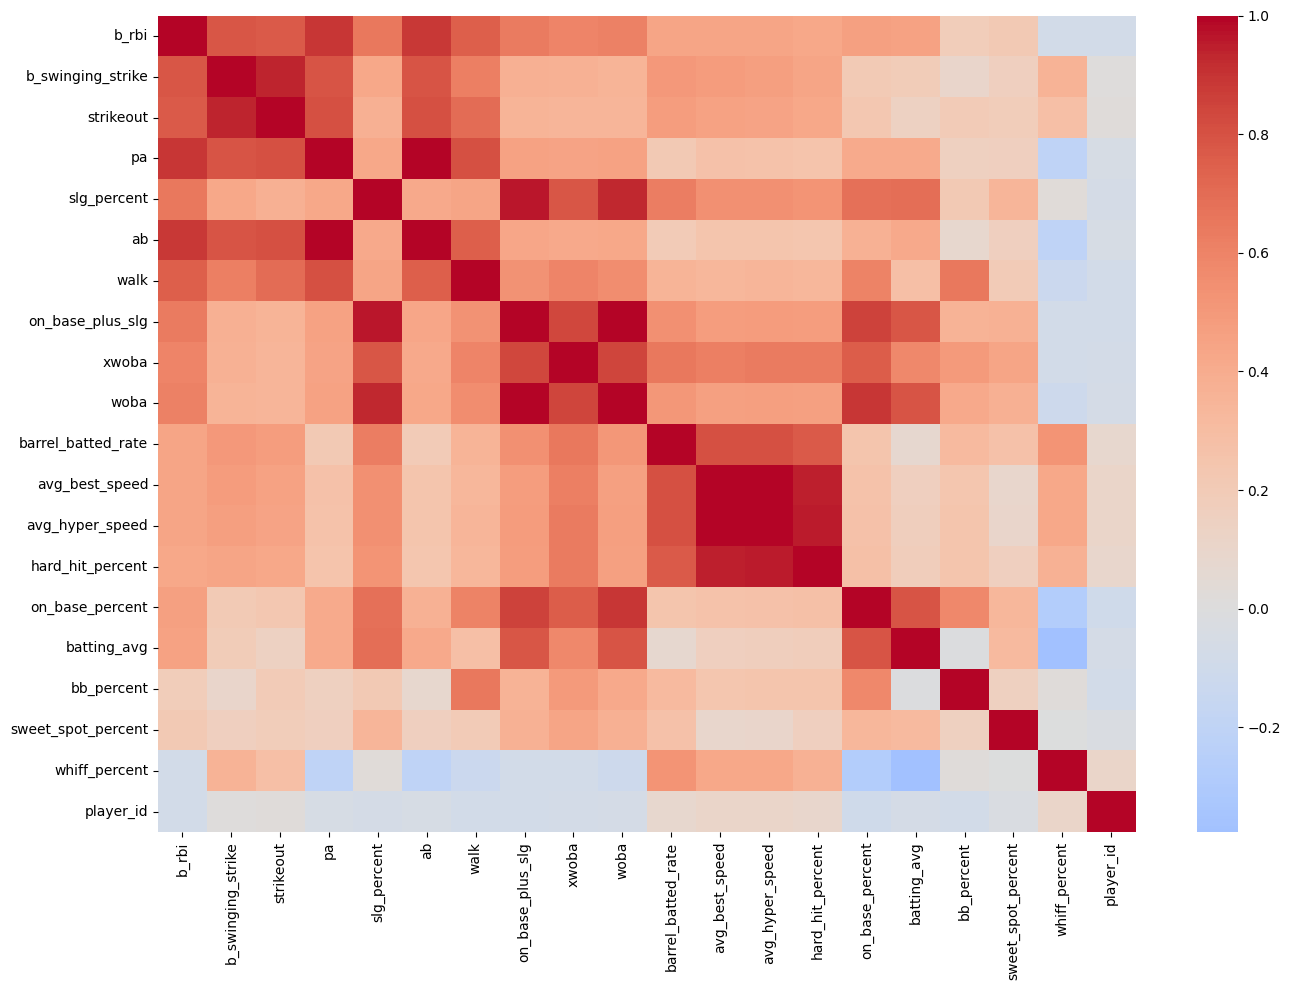

In [11]:
target = "home_run"
corr = df[numeric_cols].corr()
top20 = corr[target].abs().sort_values(ascending=False).index[1:21]
corr_top20 = corr.loc[top20, top20]
plt.figure(figsize=(14, 10))
sns.heatmap(corr_top20, annot=False, cmap="coolwarm", center=0)
plt.tight_layout()
plt.show()


## **Train/Test Split**

In [12]:
# remove non-numeric columns
id_cols = [col for col in df.columns if 'name' in col.lower() or 'id' in col.lower()]
df = df.drop(columns=id_cols, errors='ignore')

y = df['home_run']
X = df.drop(columns=['home_run'])

# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (3048, 22)
Test shape: (763, 22)


# **Decision Tree**

### Model Variant 1: Only use the top 10 correlated features with `home_run`

In [13]:
# Only get top 10
correlations = df.corr()['home_run'].abs().sort_values(ascending=False)
top10 = correlations.index[1:11]

X_train_top10 = X_train[top10]
X_test_top10 = X_test[top10]

print("Top 10 correlated features:", list(top10))

Top 10 correlated features: ['b_rbi', 'b_swinging_strike', 'strikeout', 'pa', 'slg_percent', 'ab', 'walk', 'on_base_plus_slg', 'xwoba', 'woba']


In [14]:
# Decision Tree Regressor
dt_top10 = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

dt_top10.fit(X_train_top10, y_train)

# Train/test metrics
y_train_pred = dt_top10.predict(X_train_top10)
y_test_pred  = dt_top10.predict(X_test_top10)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test,  y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test,  y_test_pred)

metrics_table = pd.DataFrame({
    "Train": [train_r2, train_rmse, train_mae],
    "Test":  [test_r2,  test_rmse,  test_mae]
}, index=["R²", "RMSE", "MAE"])

print("Train/Test metrics (Variant 1):")
display(metrics_table)

# 5-fold cross-validation metrics
# R2
cv_r2_v1 = cross_val_score(
    dt_top10,
    X_train_top10,
    y_train,
    cv=5,
    scoring="r2"
)

# RMSE
cv_mse_v1 = -cross_val_score(
    dt_top10,
    X_train_top10,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)
cv_rmse_v1 = np.sqrt(cv_mse_v1)

# AIC on training data
n = len(y_train)
rss = np.sum((y_train - y_train_pred) ** 2)
p  = dt_top10.get_n_leaves()
aic_v1 = n * np.log(rss / n) + 2 * p

# Summary table for CV + AIC (Variant 1)
cv_aic_table_v1 = pd.DataFrame({
    "CV_R²_mean":      [cv_r2_v1.mean()],
    "CV_R²_std":       [cv_r2_v1.std()],
    "CV_RMSE_mean":    [cv_rmse_v1.mean()],
    "CV_RMSE_std":     [cv_rmse_v1.std()],
    "AIC_train":       [aic_v1]
}, index=["DecisionTree_V1_Top10"])

print("5-fold CV + AIC (Variant 1):")
display(cv_aic_table_v1)

Train/Test metrics (Variant 1):


,Train,Test
R²,0.899989,0.873045
RMSE,3.110022,3.350280
MAE,2.354787,2.529734


5-fold CV + AIC (Variant 1):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
DecisionTree_V1_Top10,0.86858,0.011868,3.556315,0.152516,6980.704177


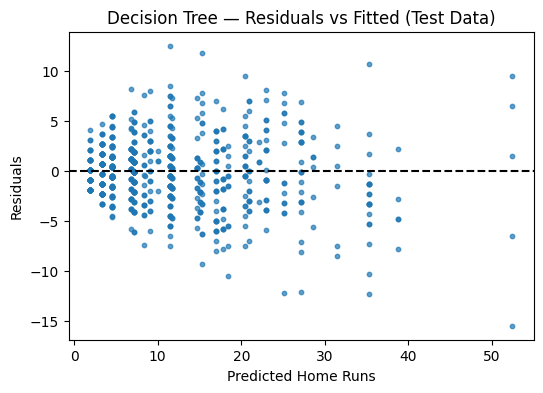

In [15]:
# Plot residual plot
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, s=10, alpha=0.7)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Home Runs")
plt.ylabel("Residuals")
plt.title("Decision Tree — Residuals vs Fitted (Test Data)")
plt.show()

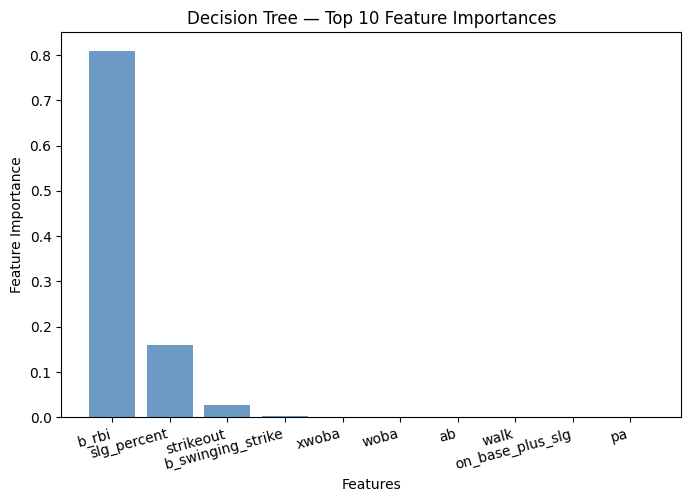

In [16]:
# Plot model feature importances
feature_importances = dt_top10.feature_importances_
orders_ft = np.argsort(feature_importances)[::-1]
features_sorted = [X_train_top10.columns[i] for i in orders_ft]
importances_sorted = feature_importances[orders_ft]

plt.figure(figsize=(8,5))
bars = plt.bar(features_sorted, importances_sorted, color='steelblue', alpha=0.8)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Decision Tree — Top 10 Feature Importances")
plt.xticks(rotation=15, ha="right")
plt.show()

### Model Variant 2: Tuned hyperparameters on all features

In [17]:
# Hyperparameter grid for DecisionTreeRegressor
dt_param_grid = {
    "max_depth": [None, 4, 6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["squared_error", "friedman_mse"],
    "splitter": ["best", "random"]
}

dt_base = DecisionTreeRegressor(random_state=42)

In [18]:
# Grid search with 5-fold CV optimizing MSE (we'll convert to RMSE)
dt_grid = GridSearchCV(estimator=dt_base,param_grid=dt_param_grid,cv=5,
    scoring="neg_root_mean_squared_error"
)

dt_grid.fit(X_train, y_train)

print("Best parameters:", dt_grid.best_params_)

Best parameters: {'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}


In [19]:
# Best tuned tree from grid search
dt_tuned = dt_grid.best_estimator_

# Predictions
y_train_pred_dt2 = dt_tuned.predict(X_train)
y_test_pred_dt2 = dt_tuned.predict(X_test)

# Metrics
train_r2_dt2 = r2_score(y_train, y_train_pred_dt2)
test_r2_dt2 = r2_score(y_test, y_test_pred_dt2)

train_rmse_dt2 = np.sqrt(mean_squared_error(y_train, y_train_pred_dt2))
test_rmse_dt2 = np.sqrt(mean_squared_error(y_test, y_test_pred_dt2))


print("Variant 2 – Tuned Hyperparameters (Decision Tree)")
print(f"Train R^2:  {train_r2_dt2:.3f}")
print(f"Test R^2:   {test_r2_dt2:.3f}")
print(f"Train RMSE: {train_rmse_dt2:.3f}")
print(f"Test RMSE:  {test_rmse_dt2:.3f}")


Variant 2 – Tuned Hyperparameters (Decision Tree)
Train R^2:  0.960
Test R^2:   0.903
Train RMSE: 1.966
Test RMSE:  2.936


In [20]:
# Structural complexity of the tuned tree
tree_depth_dt2 = dt_tuned.get_depth()
n_leaves_dt2 = dt_tuned.get_n_leaves()

print("Tuned tree depth:", tree_depth_dt2)
print("Number of leaves:", n_leaves_dt2)


Tuned tree depth: 8
Number of leaves: 199


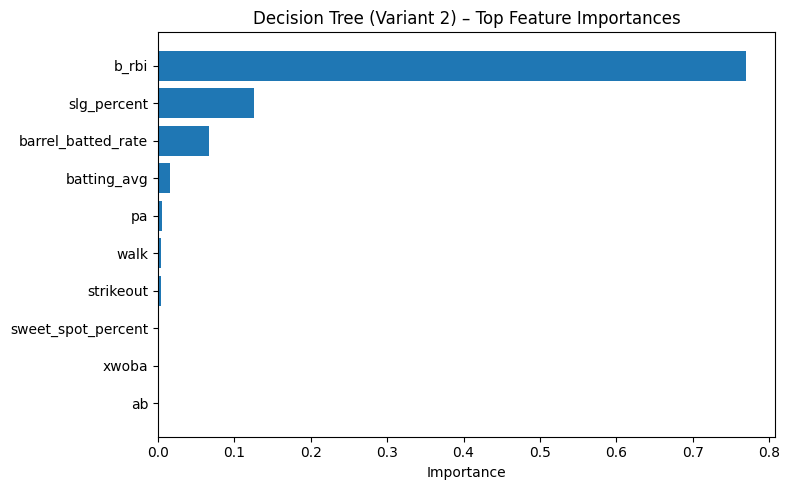

,feature,importance
11,b_rbi,0.769414
8,slg_percent,0.125650
16,barrel_batted_rate,0.066222
7,batting_avg,0.015728
2,pa,0.005220
4,walk,0.003552
3,strikeout,0.003388
15,sweet_spot_percent,0.001963
14,xwoba,0.001758
1,ab,0.001357


In [21]:
# Feature importances from the tuned tree
importances_dt2 = dt_tuned.feature_importances_
feature_names = X_train.columns

# Put into DataFrame and sort
fi_dt2 = pd.DataFrame({
    "feature": feature_names,
    "importance": importances_dt2
}).sort_values("importance", ascending=False)

# limit y to 10 columns
top_k = 10
fi_top_dt2 = fi_dt2.head(top_k)

plt.figure(figsize=(8, 5))
plt.barh(fi_top_dt2["feature"][::-1], fi_top_dt2["importance"][::-1])
plt.xlabel("Importance")
plt.title("Decision Tree (Variant 2) – Top Feature Importances")
plt.tight_layout()
plt.show()

fi_top_dt2


In [22]:
# 5-fold CV metrics for Variant 2
# R2
cv_r2_v2 = cross_val_score(
    dt_tuned,
    X_train,
    y_train,
    cv=5,
    scoring="r2"
)

# RMSE
cv_mse_v2 = -cross_val_score(
    dt_tuned,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)
cv_rmse_v2 = np.sqrt(cv_mse_v2)

# AIC computation
n2 = len(y_train)
rss2 = np.sum((y_train - y_train_pred_dt2) ** 2)
p2  = dt_tuned.get_n_leaves()
aic_v2 = n2 * np.log(rss2 / n2) + 2 * p2

# Summary table for Variant 2
cv_aic_table_v2 = pd.DataFrame({
    "CV_R²_mean":      [cv_r2_v2.mean()],
    "CV_R²_std":       [cv_r2_v2.std()],
    "CV_RMSE_mean":    [cv_rmse_v2.mean()],
    "CV_RMSE_std":     [cv_rmse_v2.std()],
    "AIC_train":       [aic_v2]
}, index=["DecisionTree_V2_Tuned"])

print("5-fold CV + AIC (Variant 2):")
display(cv_aic_table_v2)

5-fold CV + AIC (Variant 2):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
DecisionTree_V2_Tuned,0.89895,0.010388,3.115585,0.119958,4519.518886


In [23]:
# Combined CV + AIC comparison for Variant 1 and Variant 2
combined_cv_aic = pd.DataFrame({
    "CV_R²_mean":   [cv_r2_v1.mean(),      cv_r2_v2.mean()],
    "CV_R²_std":    [cv_r2_v1.std(),       cv_r2_v2.std()],
    "CV_RMSE_mean": [cv_rmse_v1.mean(),    cv_rmse_v2.mean()],
    "CV_RMSE_std":  [cv_rmse_v1.std(),     cv_rmse_v2.std()],
    "AIC_train":    [aic_v1,               aic_v2]
}, index=["V1_Top10", "V2_Tuned"])

print("Cross-validation + AIC comparison (5-fold):")
display(combined_cv_aic)

Cross-validation + AIC comparison (5-fold):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
V1_Top10,0.86858,0.011868,3.556315,0.152516,6980.704177
V2_Tuned,0.89895,0.010388,3.115585,0.119958,4519.518886


### Model Variant 3: Shallow Trees

In [24]:
# Shallow Decision Tree
dt_v3 = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=5,
    random_state=42
)

dt_v3.fit(X_train, y_train)

y_train_pred_v3 = dt_v3.predict(X_train)
y_test_pred_v3  = dt_v3.predict(X_test)


In [25]:
# Computed metrics
train_rmse_v3 = np.sqrt(mean_squared_error(y_train, y_train_pred_v3))
test_rmse_v3  = np.sqrt(mean_squared_error(y_test,  y_test_pred_v3))

train_mae_v3  = mean_absolute_error(y_train, y_train_pred_v3)
test_mae_v3   = mean_absolute_error(y_test,  y_test_pred_v3)

train_r2_v3   = r2_score(y_train, y_train_pred_v3)
test_r2_v3    = r2_score(y_test,  y_test_pred_v3)

metrics_v3 = pd.DataFrame({
    "Train_RMSE": [train_rmse_v3],
    "Test_RMSE":  [test_rmse_v3],
    "Train_MAE":  [train_mae_v3],
    "Test_MAE":   [test_mae_v3],
    "Train_R²":   [train_r2_v3],
    "Test_R²":    [test_r2_v3]
}, index=["V3_ShallowTree"])

display(metrics_v3)

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R²,Test_R²
V3_ShallowTree,4.001224,4.143744,2.984544,3.085814,0.834458,0.80579


In [26]:
# 5-fold CV metrics for Variant 3 (Shallow Tree)
# R²
cv_r2_v3 = cross_val_score(
    dt_v3,
    X_train,
    y_train,
    cv=5,
    scoring="r2"
)

# RMSE
cv_mse_v3 = -cross_val_score(
    dt_v3,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)
cv_rmse_v3 = np.sqrt(cv_mse_v3)

# AIC computation
n3   = len(y_train)
rss3 = np.sum((y_train - y_train_pred_v3) ** 2)
p3   = dt_v3.get_n_leaves()

if rss3 <= 0:
    aic_v3 = np.inf
else:
    aic_v3 = n3 * np.log(rss3 / n3) + 2 * p3

# Summary table for Variant 3
cv_aic_table_v3 = pd.DataFrame({
    "CV_R²_mean":      [cv_r2_v3.mean()],
    "CV_R²_std":       [cv_r2_v3.std()],
    "CV_RMSE_mean":    [cv_rmse_v3.mean()],
    "CV_RMSE_std":     [cv_rmse_v3.std()],
    "AIC_train":       [aic_v3]
}, index=["DecisionTree_V3_Shallow"])

print("5-fold CV + AIC (Variant 3):")
display(cv_aic_table_v3)


5-fold CV + AIC (Variant 3):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
DecisionTree_V3_Shallow,0.825946,0.011634,4.093845,0.093478,8468.715804


## **Variants Summary**

In [27]:
# Combined 5-fold CV + AIC comparison for Variants 1, 2, and 3

combined_cv_aic = pd.DataFrame({
    "CV_R²_mean":   [cv_r2_v1.mean(),   cv_r2_v2.mean(),   cv_r2_v3.mean()],
    "CV_RMSE_mean": [cv_rmse_v1.mean(), cv_rmse_v2.mean(), cv_rmse_v3.mean()],
    "AIC_train":    [aic_v1,            aic_v2,            aic_v3]
}, index=[
    "V1_Top10",
    "V2_Tuned",
    "V3_Shallow"
])

print("Combined 5-fold CV + AIC (Variants 1, 2, 3):")
display(combined_cv_aic)


Combined 5-fold CV + AIC (Variants 1, 2, 3):


,CV_R²_mean,CV_RMSE_mean,AIC_train
V1_Top10,0.868580,3.556315,6980.704177
V2_Tuned,0.898950,3.115585,4519.518886
V3_Shallow,0.825946,4.093845,8468.715804


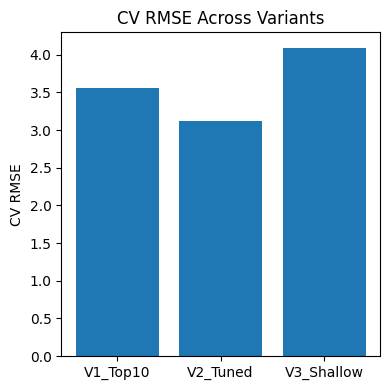

In [28]:
# RMSE Comparison
variants = [
    "V1_Top10",
    "V2_Tuned",
    "V3_Shallow"
]

cv_rmse_values = [
    cv_rmse_v1.mean(),
    cv_rmse_v2.mean(),
    cv_rmse_v3.mean()
]

# Create bar chart
plt.figure(figsize=(4,4))
plt.bar(variants, cv_rmse_values)
plt.ylabel("CV RMSE")
plt.title("CV RMSE Across Variants")
plt.tight_layout()
plt.show()


## **QnA Defense**

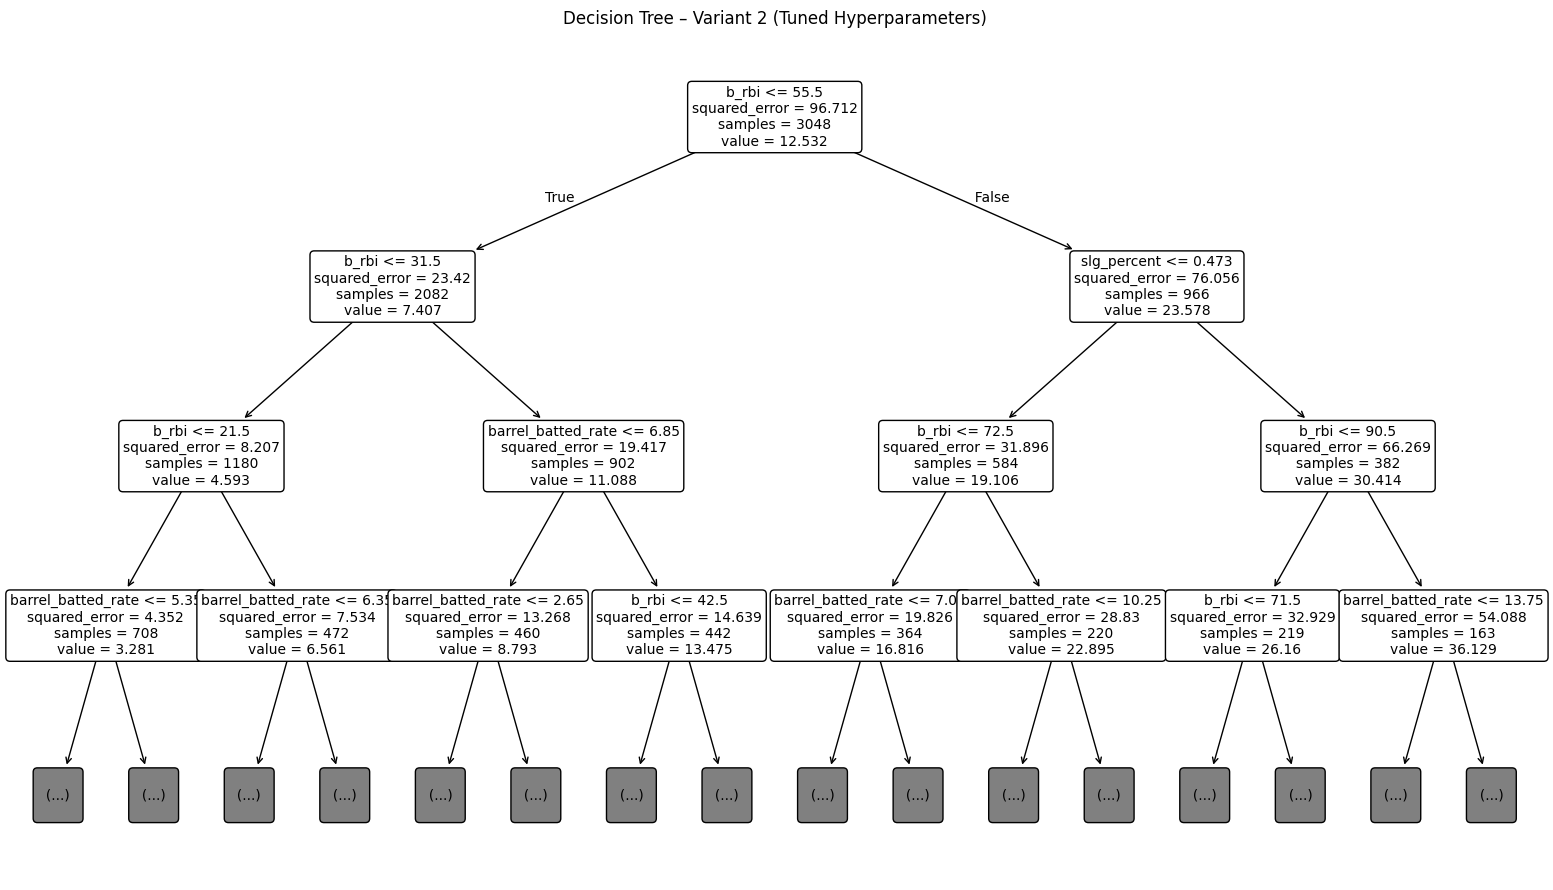

In [29]:
from sklearn.tree import plot_tree

# Tree diagram for Variant 2 (tuned tree)
plt.figure(figsize=(16, 9))

plot_tree(
    dt_tuned,
    feature_names=X_train.columns,
    max_depth=3,
    filled=False,
    rounded=True,
    fontsize=10
)

plt.title("Decision Tree – Variant 2 (Tuned Hyperparameters)")
plt.tight_layout()
plt.show()


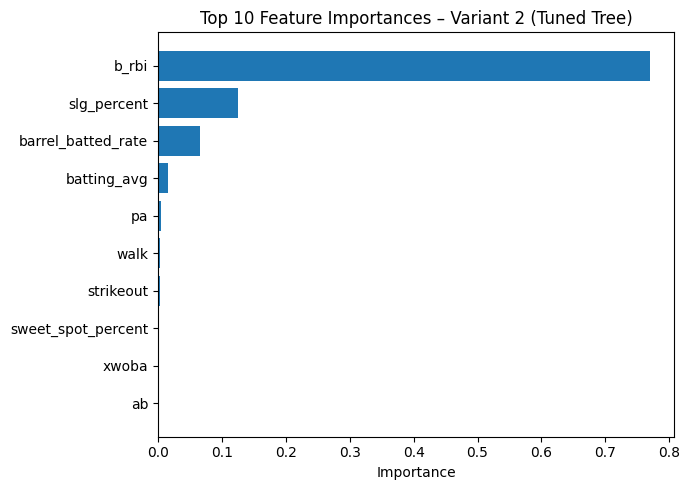

In [30]:
# Get importances
importances_v2 = dt_tuned.feature_importances_
feature_names = X_train.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances_v2
}).sort_values("importance", ascending=False)

# Keep only top 10
fi_top10 = fi_df.head(10)

plt.figure(figsize=(7, 5))
plt.barh(fi_top10["feature"][::-1], fi_top10["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances – Variant 2 (Tuned Tree)")
plt.tight_layout()
plt.show()


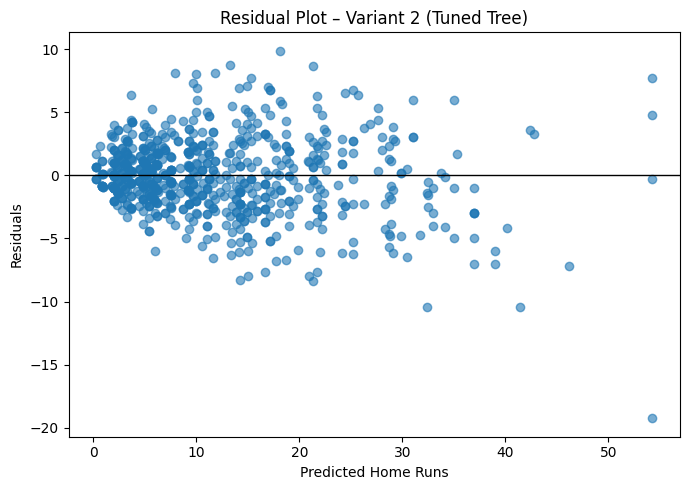

In [31]:
# Residuals for Variant 2
residuals_v2 = y_test - y_test_pred_dt2

plt.figure(figsize=(7, 5))
plt.scatter(y_test_pred_dt2, residuals_v2, alpha=0.6)
plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Predicted Home Runs")
plt.ylabel("Residuals")
plt.title("Residual Plot – Variant 2 (Tuned Tree)")
plt.tight_layout()
plt.show()